# Numerical Example 4.2: Mandel's Problem

* Author: Jhabriel Varela
* E-mail: jhabriel.varela@uib.no
* Date: 11.06.2019
* Institution: PMG - UiB - Norway

## Description of the problem

Mandel's problem is a well known two-dimensional benchmark problem which admits an analytical solution. It was originally presented by Mandel [[1](#ref)], who developed an analytical solution for the pressure. Later, Abousleiman [[2](#ref)] extended the solutions for the displacement and vertical stress. 

Mandel's problem consists of a poroelastic slab of length $2a$ in the horizontal direction and $2b$ in the vertical direction. The slab is sandwiched by two rigid plates (see left figure). Initially, two loads of equal magnitude and opposite signs are applied to the slab at the top and bottom of the domain. This sudden compression triggers a consolidation process whitin the slab, causing the pressure to increase up to a maximum value and then to monotonically decrease up to zero. 

Interestingly enough, the pressure and the horizontal component of the displacement only depend on the x-coordinate, and the vertical component of the displacement only depend on the y-coordinate. Nevertheless, we encounter a tricky situation when it comes to the treatment of boundary conditions. Since the loads are applied through rigid plates, neither the traction nor the displacement are known at the top boundary. To cope with this situation, we exploit the symmetry of the problem, which allow us to focus only on the quarter positive domain (see right figure). 

Since the solution is symmetric, we can represent the computational domain as in the right figure, where the boundary conditions for the mechanics and flow are shown. Moreover, instead of prescribing a load, we use the analytical solution (see below) to impose a vertical displacement at the top of the domain at each time step. This will allow us to recover the pressure and displacement fields, which in turn, can be compared with the known solution. 

![](mandel_domain.png)

## The analytical solution

Here we state the analytical solution of the quarter domain Mandel's problem. A thorough discussion can be found in [[3](ref)].

The pressure and the displacements are given by:

$$
p(x,t) = \frac{2FB(1+\nu_u)}{3a} \sum_{n=1}^{\infty} \frac{\sin{\alpha_n}}{\alpha_n - \sin{\alpha_n}\cos{\alpha_n}} \left(\cos{\frac{\alpha_n x}{a} - \cos{\alpha_n}}\right) \exp{\left(-\alpha_n^2c_ft/a^2\right)},
$$

$$
u_x(x,t) = \left[\frac{F\nu}{2\mu a} - \frac{F\nu_u}{\mu a} \sum_{n=1}^{\infty} \frac{\sin{\alpha_n}\cos{\alpha_n}}{\alpha_n - \sin{\alpha_n \cos{\alpha_n}}} \exp{\left(-\alpha_n^2c_ft/a^2\right)}\right] x + \frac{F}{\mu} \sum_{n=1}^{\infty} \frac{\cos{\alpha_n}}{\alpha_n - \sin{\alpha_n}\cos{\alpha_n}} \sin{\frac{\alpha_n x}{a}} \exp{\left(-\alpha_n^2c_ft/a^2\right)},
$$

$$
u_y(y,t) = \left[\frac{-F(1-\nu)}{2\mu a} + \frac{F(1-\nu_u)}{\mu a}  \sum_{n=1}^{\infty} \frac{\sin{\alpha_n}\cos{\alpha_n}}{\alpha_n - \sin{\alpha_n \cos{\alpha_n}}} \exp{\left(-\alpha_n^2c_ft/a^2\right)}\right] y,
$$

where $F$ is the applied vertical force $[N/m]$, $B$ is the Skempton's coefficient $[-]$, $\nu$ and $\nu_u$ are drained and undrained Poisson's coefficients $[-]$, $\mu$ is the shear modulus $[Pa]$, $c_f$ is the fluid diffusivity coefficient $[m^2/s]$ and $a$ and $b$ are the horizontal and vertical lengths of the (quarter) domain $[m]$. We note that, for the above equations, $\alpha_n$ represents the positive roots to the (non-linear) equation

$$
\tan{\alpha_n} = \frac{1-\nu}{\nu_u-\nu} \alpha_n,
$$

which must be solved numerically.

The initial conditions are given by:

$$
    p(x,0) = \frac{FB(1+\nu_u)}{3a},
$$

$$
    u_x(x,0) = \frac{F\nu_u}{2\mu a} x,
$$

$$
    u_y(y,0) = \frac{-F(1-\nu_u)}{2\mu a} y.
$$

## Importing modules

In [1]:
import itertools
import numpy as np
import matplotlib.pyplot as plt
import porepy as pp
import scipy.sparse as sps
import scipy.optimize as opt
import seaborn as sns
import sys

from matplotlib.ticker import FormatStrFormatter

## Functions

### Extracting data from the analytical solution

In [2]:
def extract_mandel_data(grid_object, 
                        data_dictionary,
                        parameter_keyword_flow,
                        parameter_keyword_mechanics):
    """
    Computes the exact solution of Mandel's problem.

    The function assumes that all the necessary fields
    are present inside the data dicitionary,

    Parameters:
        grid_object (PorePy object)         : PorePy grid object
        data_dictionary (Dictionary)        : Model's data dictionary
        parameter_keyword_flow (String)     : Keyword for the flow parameters
        parameter_keyword_mechanics (String): Keyword for the mechs parameters

    Returns:
        mandel_dict (Dictionary): Containing exact solutions and top bc
    """

    # Renaming input data
    g = grid_object
    d = data_dictionary
    kw_f = parameter_keyword_flow
    kw_m = parameter_keyword_mechanics

    # Retrieving data from the grid object
    [Nx, Ny] = g.cart_dims        # Number of cells in each direction
    a = g.bounding_box()[1][0]    # [m] This is the same as Lx
    b = g.bounding_box()[1][1]    # [m] This is the same as Ly

    xc = g.cell_centers[0]        # [m] x-cell-centers
    yc = g.cell_centers[1]        # [m] y-cell-centers
    yf = g.face_centers[1]        # [m] y-face-centers

    b_faces = g.tags["domain_boundary_faces"].nonzero()[0]   # boundary faces
    y_max = b_faces[g.face_centers[1, b_faces] > 0.9999*b]   # faces top bc

    # Retrieving data from the data dictionary
    c_f = d[pp.PARAMETERS][kw_f]["fluid_diffusivity"]
    times = d[pp.PARAMETERS][kw_f]["time_values"]

    F = d[pp.PARAMETERS][kw_m]["applied_load"]
    mu_s = d[pp.PARAMETERS][kw_m]["lame_mu"]
    nu_s = d[pp.PARAMETERS][kw_m]["poisson_coefficient"]
    B = d[pp.PARAMETERS][kw_m]["skempton_coefficient"]
    nu_u = d[pp.PARAMETERS][kw_m]["undrained_poisson_coefficient"]

    # Create empty dictionary to store analytical solutions and boundary terms
    mandel_dict = {"pressure": np.zeros((len(times), g.num_cells)),
                   "displacement": np.zeros((len(times), g.dim*g.num_cells)),
                   "top_bc_values": np.zeros((len(times), len(y_max)))}

    # Compute analytical solution and top boundary condition

    # Numerical approximation to the the roots of f(x) = 0, where
    # f(x) = tan(x) - ((1-nu)/(nu_u-nu)) x.

    """
    Note that we have to solve the above equation numerically to get
    all the positive solutions to the equation. Later we will use them to
    compute the infinite series. Experience has shown that 200 roots are enough
    to achieve accurate results. Note: We find the roots using the bisection
    method, Newton method fails.
    """

    # Define algebraic function
    def f(x):
        y = np.tan(x) - ((1-nu_s)/(nu_u-nu_s))*x
        return y

    n_series = 200              # number of approimated roots
    a_n = np.zeros(n_series)    # initializing roots array
    x0 = 0                      # initial point
    for i in range(n_series):
        a_n[i] = opt.bisect(f,  # function
                            x0+np.pi/4,  # left point
                            x0+np.pi/2-10000000*2.2204e-16,  # right point
                            xtol=1e-30,  # absolute tolerance
                            rtol=1e-14)  # relative tolerance
        x0 += np.pi           # apply a phase change of pi to get the next root

    # Auxiliary (constant) terms necessary to compute the solutions
    p0 = (2*F*B*(1+nu_u)) / (3*a)

    ux0_1 = ((F*nu_s) / (2*mu_s*a))
    ux0_2 = -((F*nu_u) / (mu_s*a))
    ux0_3 = F/mu_s

    uy0_1 = (-F*(1-nu_s)) / (2*mu_s*a)
    uy0_2 = (F*(1-nu_u) / (mu_s*a))

    # Determine solutions for all the time steps (including initial condition)

    aa_n = a_n[:, np.newaxis]  # preparing to broadcast

    for t in range(len(times)):

        # Pressures
        p_sum = np.sum(((np.sin(aa_n))/(aa_n - (np.sin(aa_n) * np.cos(aa_n))))
                       * (np.cos((aa_n*xc)/a) - np.cos(aa_n))
                       * np.exp((-(aa_n**2) * c_f * times[t])/(a**2)),
                       axis=0)
        mandel_dict["pressure"][t] = p0 * p_sum

        # Displacements
        ux_sum1 = np.sum((np.sin(aa_n)*np.cos(aa_n))
                         / (aa_n - np.sin(aa_n)*np.cos(aa_n))
                         * np.exp((-(aa_n**2) * c_f * times[t])/(a**2)),
                         axis=0)
        ux_sum2 = np.sum((np.cos(aa_n)/(aa_n - (np.sin(aa_n) * np.cos(aa_n))))
                         * np.sin((aa_n * xc)/a)
                         * np.exp((-(aa_n**2) * c_f * times[t])/(a**2)),
                         axis=0)
        uy_sum = np.sum(((np.sin(aa_n) * np.cos(aa_n))
                         / (aa_n - np.sin(aa_n) * np.cos(aa_n)))
                        * np.exp((-(aa_n**2) * c_f * times[t])/(a**2)),
                        axis=0)
        ux = (ux0_1 + ux0_2*ux_sum1) * xc + ux0_3 * ux_sum2
        uy = (uy0_1 + uy0_2*uy_sum) * yc
        mandel_dict["displacement"][t] = np.array((ux, uy)).ravel("F")

        # Time-dependent dirichlet boundary condition to be imposed at the top
        mandel_dict["top_bc_values"][t] = (uy0_1 + uy0_2*uy_sum) * yf[y_max]

    return mandel_dict

### Grid generation

In [3]:
def make_grid(N=[40, 40], L=[100, 10]):
    """
    Creates a structured cartesian grid.

    Parameters:
        N (array): number of cells for each dimension [-]
        L (array): length of the domain for each dimension [m]

    Returns:
        gb (PorePy object): PorePy grid bucket object containing all the grids
                            In this case we only have one grid.
    """

    gb = pp.meshing.cart_grid([], N, physdims=L)  # create cartesian grid
    gb.compute_geometry()  # compute the grid geometry
    gb.assign_node_ordering()  # assign node ordering in the grid bucket

    return gb

### Time parameters

In [4]:
def set_time_parameters(data_dictionary,
                        parameter_keyword_flow):
    """
    Sets the time parameters for the coupled problem.

    Parameters:
        d (Dictionary): Model's data dictionary
        parameter_keyword_flow (String): Keyword for the flow parameter

    Note: This function does not return any value, but rather updates the data
          dictionary. The data is stored in the time parameters.
    """

    # Renaming input data
    d = data_dictionary
    kw_f = parameter_keyword_flow

    # Declaring time parameters (These parameters must be set by the user)
    initial_simulation_time = 0     # [s]
    final_simulation_time = 50000   # [s]
    time_step = 10                  # [s]
    time_values = np.arange(initial_simulation_time,
                            final_simulation_time+time_step,
                            time_step)

    # Storing in the dictionary
    d[pp.PARAMETERS][kw_f]["initial_time"] = initial_simulation_time
    d[pp.PARAMETERS][kw_f]["final_time"] = final_simulation_time
    d[pp.PARAMETERS][kw_f]["time_step"] = time_step
    d[pp.PARAMETERS][kw_f]["time_values"] = time_values

### Model's data

In [5]:
def set_model_data(data_dictionary,
                   parameter_keyword_flow,
                   parameter_keyword_mechanics):
    """
    Declaration of the model's data.

    Parameters:
        data_dictionary (Dictionary)        : Data dictionary
        parameter_keyword_flow (String)     : Keyword for the flow parameters.
        parameter_keyword_mechanics (String): Keyword for the mech parameters.

    Note: This function does not return any value, but rather updates the data
          dictionary.
    """

    # Renaming input data
    d = data_dictionary
    kw_f = parameter_keyword_flow
    kw_m = parameter_keyword_mechanics

    # Declaring model data (These parameters must be set by the user)
    # In this example we use the data from
    # https://link.springer.com/article/10.1007/s10596-013-9393-8

    mu_s = 2.475E+09                        # [Pa] First Lame parameter
    lambda_s = 1.65E+09                     # [Pa] Second Lame parameter
    K_s = (2/3) * mu_s + lambda_s           # [Pa] Bulk modulus
    E_s = mu_s * ((9*K_s)/(3*K_s+mu_s))     # [Pa] Young's modulus
    nu_s = (3*K_s-2*mu_s)/(2*(3*K_s+mu_s))  # [-] Poisson's coefficient
    k_s = 0.1 * 9.869233E-13                # [m^2] Permeabiliy
    alpha_biot = 1.                         # [-] Biot's coefficient

    mu_f = 1.0E-3                           # [Pa s] Dynamic viscosity

    S_m = 1/1.65E10                         # [1/Pa] Specific Storage
    K_u = K_s + (alpha_biot**2)/S_m         # [Pa] Undrained bulk modulus
    B = alpha_biot / (S_m * K_u)            # [-] Skempton's coefficient
    nu_u = ((3*nu_s + B*(1-2*nu_s))         # [-] Undrained Poisson's ratio
            / (3-B*(1-2*nu_s)))
    c_f = ((2*k_s*(B**2)*mu_s*(1-nu_s)*(1+nu_u)**2)  # m^2/s Fluid diffusivity
           / (9*mu_f*(1-nu_u)*(nu_u-nu_s)))

    F = 6.0E8                               # [N/m] Applied load

    # Storing in the dictionary
    d[pp.PARAMETERS][kw_f]["viscosity"] = mu_f
    d[pp.PARAMETERS][kw_f]["alpha_biot"] = alpha_biot
    d[pp.PARAMETERS][kw_f]["specific_storage"] = S_m
    d[pp.PARAMETERS][kw_f]["fluid_diffusivity"] = c_f
    d[pp.PARAMETERS][kw_f]["permeability"] = k_s

    d[pp.PARAMETERS][kw_m]["lame_mu"] = mu_s
    d[pp.PARAMETERS][kw_m]["lame_lambda"] = lambda_s
    d[pp.PARAMETERS][kw_m]["bulk_modulus"] = K_s
    d[pp.PARAMETERS][kw_m]["young_modulus"] = E_s
    d[pp.PARAMETERS][kw_m]["poisson_coefficient"] = nu_s
    d[pp.PARAMETERS][kw_m]["alpha_biot"] = alpha_biot
    d[pp.PARAMETERS][kw_m]["skempton_coefficient"] = B
    d[pp.PARAMETERS][kw_m]["undrained_poisson_coefficient"] = nu_u
    d[pp.PARAMETERS][kw_m]["applied_load"] = F

### Boundary conditions

In [6]:
def set_boundary_conditions(grid_object,
                            data_dictionary,
                            parameter_keyword_flow,
                            parameter_keyword_mechanics,
                            mandel_dictionary):
    """
    Sets the boundary conditions for the coupled problem.

    Parameters:
        grid_object (PorePy object)         : PorePy grid object.
        data_dictionary (Dictionary)        : Model's data dictionary.
        parameter_keyword_flow (String)     : Keyword for the flow parameters.
        parameter_keyword_mechanics (String): Keyword for the mech parameters.
        mandel_dictionary (Dictionary)      : Containing the solutions and
                                              top boundary condition
    Returns:
        bc_dictionary (dictionary): containing the bc objects and values for
                                    the flow and mechanics problems.
    """

    # Renaming input data
    g = grid_object
    d = data_dictionary
    kw_f = parameter_keyword_flow
    kw_m = parameter_keyword_mechanics
    d_m = mandel_dictionary
    times = d[pp.PARAMETERS][kw_f]["time_values"]

    # Retrieving data from the grid object
    [Nx, Ny] = g.cart_dims      # Number of cells in each direction
    a = g.bounding_box()[1][0]  # [m] This is the same as Lx
    b = g.bounding_box()[1][1]  # [m] This is the same as Ly

    # Getting the boundary faces
    b_faces = g.tags['domain_boundary_faces'].nonzero()[0]

    # Extracting indices of boundary faces w.r.t g
    x_min = b_faces[g.face_centers[0, b_faces] < 0.0001]
    x_max = b_faces[g.face_centers[0, b_faces] > 0.9999*a]
    y_min = b_faces[g.face_centers[1, b_faces] < 0.0001]
    y_max = b_faces[g.face_centers[1, b_faces] > 0.9999*b]

    # Extracting indices of boundary faces w.r.t b_faces
    west = np.in1d(b_faces, x_min).nonzero()
    east = np.in1d(b_faces, x_max).nonzero()
    south = np.in1d(b_faces, y_min).nonzero()
    north = np.in1d(b_faces, y_max).nonzero()

    # Set flow boundary conditions [Time-independent Boundary Condition]

    # Setting the tags at each boundary side
    labels_flow = np.array([None]*b_faces.size)
    labels_flow[west] = 'neu'   # no flow
    labels_flow[east] = 'dir'   # constant pressure
    labels_flow[south] = 'neu'  # no flow
    labels_flow[north] = 'neu'  # no flow

    # Constructing the (scalar) bc object
    bc_flow = pp.BoundaryCondition(g, b_faces, labels_flow)

    # Constructing the boundary values array
    bc_flow_values = np.zeros(g.num_faces)

    # West side boundary condition
    bc_flow_values[x_min] = 0  # [m^3/s]

    # East side boundary condition
    bc_flow_values[x_max] = 0  # [Pa]

    # South side boundary condition
    bc_flow_values[y_min] = 0  # [m^3/s]

    # North side boundary condition
    bc_flow_values[y_max] = 0  # [m^3/s]

    # Set mechanics boundary conditions [Time-dependent Boundary Condition]

    # Applied displacement (time-dependent boundary condition)
    u_top = d_m["top_bc_values"]

    # Setting the tags at each boundary side for the mechanics problem
    labels_mech = np.array([None]*b_faces.size)
    labels_mech[west] = 'dir_x'   # roller
    labels_mech[east] = 'neu'     # traction free
    labels_mech[south] = 'dir_y'  # roller
    labels_mech[north] = 'dir_y'  # roller (with non-zero uy)

    # Constructing the bc object for the mechanics problem
    bc_mech = pp.BoundaryConditionVectorial(g, b_faces, labels_mech)

    # Constructing the boundary values array for the mechanics problem
    bc_mech_values = np.zeros((len(times), g.num_faces*g.dim,))

    for t in range(len(times)):

        # West side boundary conditions
        bc_mech_values[t][2*x_min] = 0           # [m]
        bc_mech_values[t][2*x_min+1] = 0         # [Pa]

        # East side boundary conditions
        bc_mech_values[t][2*x_max] = 0           # [Pa]
        bc_mech_values[t][2*x_max+1] = 0         # [Pa]

        # South Side boundary conditions
        bc_mech_values[t][2*y_min] = 0           # [Pa]
        bc_mech_values[t][2*y_min+1] = 0         # [m]

        # North Side boundary conditions
        bc_mech_values[t][2*y_max] = 0           # [Pa]
        bc_mech_values[t][2*y_max+1] = u_top[t]  # [m]

    # Saving boundary conditions in a dictionary
    bc_dictionary = dict()

    bc_dictionary[kw_f] = {"bc": bc_flow,
                           "bc_values": bc_flow_values}

    bc_dictionary[kw_m] = {"bc": bc_mech,
                           "bc_values": bc_mech_values}

    return bc_dictionary

### Assign model's data

In [7]:
def assign_data(grid_object,
                data_dictionary,
                boundary_conditions_dictionary,
                parameter_keyword_flow,
                parameter_keyword_mechanics):
    """
    Assign data to the model, which will later be used to discretize
    the coupled problem.

    Parameters:
        grid_object (PorePy object)                 : PorePy grid object
        data_dictionary (Dictionary)                : Model's data dictionary
        boundary_conditions_dictionary (Dicitionary): Boundary conditions
        parameter_keyword_flow (String)             : Keyword for the flow par.
        parameter_keyword_mechanics (String)        : Keyword for the mech par.

    Note: This function does not return any output. Instead, the data dict
          is updated with the proper fields.
    """

    # Renaming input data
    g = grid_object
    d = data_dictionary
    bc_dict = boundary_conditions_dictionary
    kw_f = parameter_keyword_flow
    kw_m = parameter_keyword_mechanics

    # Assing flow data

    # Retrieve data for the flow problem
    k = d[pp.PARAMETERS][kw_f]["permeability"]
    alpha_biot = d[pp.PARAMETERS][kw_f]["alpha_biot"]
    S_m = d[pp.PARAMETERS][kw_f]["specific_storage"]
    dt = d[pp.PARAMETERS][kw_f]["time_step"]

    bc_flow = bc_dict[kw_f]["bc"]
    bc_flow_values = bc_dict[kw_f]["bc_values"]

    # Create second order tensor object
    perm = pp.SecondOrderTensor(g.dim,
                                k * np.ones(g.num_cells))

    # Create specified parameters dicitionary
    specified_parameters_flow = {"second_order_tensor": perm,
                                 "biot_alpha": alpha_biot,
                                 "bc": bc_flow,
                                 "bc_values": bc_flow_values,
                                 "time_step": dt,
                                 "mass_weight": S_m * np.ones(g.num_cells)}

    # Initialize the flow data
    d = pp.initialize_default_data(g, d, kw_f, specified_parameters_flow)

    # Assign mechanics data

    # Retrieve data for the mechanics problem
    mu = d[pp.PARAMETERS][kw_m]["lame_mu"]
    lmbda = d[pp.PARAMETERS][kw_m]["lame_lambda"]
    alpha_biot = d[pp.PARAMETERS][kw_m]["alpha_biot"]

    bc_mech = bc_dict[kw_m]["bc"]
    bc_mech_values = bc_dict[kw_m]["bc_values"][1]

    # Create fourth order tensor
    constit = pp.FourthOrderTensor(g.dim,
                                   mu * np.ones(g.num_cells),
                                   lmbda * np.ones(g.num_cells))

    # Create specified parameters dicitionary
    specified_parameters_mechanics = {"fourth_order_tensor": constit,
                                      "biot_alpha": alpha_biot,
                                      "bc": bc_mech,
                                      "bc_values": bc_mech_values}

    # Initialize the mechanics
    d = pp.initialize_default_data(g, d, kw_m, specified_parameters_mechanics)

    # Save boundary conditions in d[pp.STATE]
    pp.set_state(d, {kw_m: {"bc_values": bc_dict[kw_m]["bc_values"][0]}})

### Initial condition

In [8]:
def initial_condition(data_dictionary,
                      variable_flow,
                      variable_mechanics,
                      mandel_dictionary):
    """
    Establishes initial condition.

    Parameters:
        data_dictionary (Dictionary)  : Model's data dictionary
        variable_flow (String)        : Keyword for the flow primary variable
        variable_mechanics (String)   : Keyword for the mechs primary variable
        mandel_dictionary (Dictionary): Containing the solutions and the
                                        top boundary condition.
    """

    d_0 = mandel_dictionary["displacement"][0]
    p_0 = mandel_dictionary["pressure"][0]

    state = {variable_m: d_0, variable_f: p_0}

    pp.set_state(data_dictionary, state)

    return d_0, p_0

## Setting up the grid, defining keywords and creating data dictionary

In [9]:
# Define a grid (User defined)
gb = make_grid()
g = gb.grids_of_dimension(2)[0]

# Defining keywords and primary variable names
kw_f = "flow"
kw_m = "mechanics"
variable_f = "pressure"
variable_m = "displacement"

# Create data dicitionary and initialize
data = gb.node_props(g)
data = pp.initialize_default_data(g, data, kw_f)
data = pp.initialize_default_data(g, data, kw_m)

## Setting parameters, assigning data and computing initial condition


In [10]:
# Set time parameters (User-defined)
set_time_parameters(data, kw_f)  

# Set model's data (User-defined)
set_model_data(data, kw_f, kw_m)  

# Extract data from analytical solution
mandel_dict = extract_mandel_data(g, data, kw_f, kw_m)

# Retrieve boundary conditions
bc_dict = set_boundary_conditions(g, data, kw_f, kw_m, mandel_dict)

# Assigning data to the model
assign_data(g, data, bc_dict, kw_f, kw_m)

# Computing initial condition
d_0, p_0 = initial_condition(data, variable_f, variable_m, mandel_dict)

## Perform discretization

Now we discretize the problem using the Biot's class, which uses
the MPSA discretization for the mechanics problem and MPFA for the
flow problem.

In [11]:
biot_discretizer = pp.Biot(kw_m, kw_f, variable_m, variable_f)
biot_discretizer._discretize_mech(g, data)  # discretize mech problem
biot_discretizer._discretize_flow(g, data)  # discretize flow problem

number of ncasym eliminated:  4
max igrad:  58228358.818527624


## Assembly of equations

First, we modify some classes to account for the implicit Euler
discretization in time (see Biot's tutorial for a detailed explanation):

In [12]:
class ImplicitMassMatrix(pp.MassMatrix):

    def __init__(self, keyword="flow", variable="pressure"):
        """
        Set the discretization, with the keyword used for storing various
        information associated with the discretization. The time discretisation
        also requires the previous solution, thus the variable needs to be
        specified.

        Paramemeters:
            keyword (str) : Identifier of all parameters used for this
                            discretization.
            variable (str): Name of the variable the discretization is applied.
        """
        super().__init__(keyword)
        self.variable = variable

    def assemble_rhs(self, g, data):
        """
        Overwrite MassMatrix method to
        Return the correct rhs for an IE time discretization
        of the Biot problem.
        """

        matrix_dictionary = data[pp.DISCRETIZATION_MATRICES][self.keyword]
        previous_pressure = data[pp.STATE][self.variable]

        return matrix_dictionary["mass"] * previous_pressure

In [13]:
class ImplicitMpfa(pp.Mpfa):

    def assemble_matrix_rhs(self, g, data):
        """
        Overwrite MPFA method to be consistent with Biot's
        time discretization
        """

        viscosity = data[pp.PARAMETERS][self.keyword]["viscosity"]
        a, b = super().assemble_matrix_rhs(g, data)
        dt = data[pp.PARAMETERS][self.keyword]["time_step"]
        return a * (1/viscosity) * dt, b * (1/viscosity) * dt

In [14]:
# Variable names
v_0 = variable_m
v_1 = variable_f

# Names of the five terms of the equation + additional stabilization term.
#                                        Term in the Biot equation:
term_00 = "stress_divergence"          # div symmetric grad u
term_01 = "pressure_gradient"          # alpha grad p
term_10 = "displacement_divergence"    # d/dt alpha div u
term_11_0 = "fluid_mass"               # d/dt beta p
term_11_1 = "fluid_flux"               # div (rho g - K grad p)
term_11_2 = "stabilization"            #

# Store in the data dictionary d and specify discretization objects.
data[pp.PRIMARY_VARIABLES] = {v_0: {"cells": g.dim}, v_1: {"cells": 1}}
data[pp.DISCRETIZATION] = {
    v_0: {term_00: pp.Mpsa(kw_m)},
    v_1: {
        term_11_0: ImplicitMassMatrix(kw_f, v_1),
        term_11_1: ImplicitMpfa(kw_f),
        term_11_2: pp.BiotStabilization(kw_f, v_1),
    },
    v_0 + "_" + v_1: {term_01: pp.GradP(kw_m)},
    v_1 + "_" + v_0: {term_10: pp.DivD(kw_m, v_0)},
}

## Solving

In [15]:
time_values = data[pp.PARAMETERS][kw_f]["time_values"]

# Let's create a dictionary to store the solutions
sol = {"pressure": np.zeros((len(time_values), g.num_cells)),
       "displacement": np.zeros((len(time_values), g.dim*g.num_cells))}
sol["pressure"][0] = p_0
sol["displacement"][0] = d_0

pressure = p_0
displacement = d_0
assembler = pp.Assembler(gb)    # assembly equation (note that the structure
                                # of the linear system is time independent)

for t in range(len(time_values)-1):

    # Update data for current time
    pp.set_state(data, {variable_m: displacement, variable_f: pressure})
    pp.set_state(data, {kw_m: {"bc_values": bc_dict[kw_m]["bc_values"][t]}})
    data[pp.PARAMETERS][kw_m]["bc_values"] = bc_dict[kw_m]["bc_values"][t+1]

    # Assemble and solve
    A, b = assembler.assemble_matrix_rhs()
    x = sps.linalg.spsolve(A, b)

    # Distribute primary variables
    assembler.distribute_variable(x)
    displacement = data[variable_m]
    pressure = data[variable_f]

    # Save in solution dictionary
    sol["pressure"][t+1] = pressure
    sol["displacement"][t+1] = displacement

    # Print progress on console
    sys.stdout.write("\rSimulation progress: %d%%" %
                     (np.ceil((t/(len(time_values)-2))*100)))
    sys.stdout.flush()

Simulation progress: 100%

## Plotting solutions

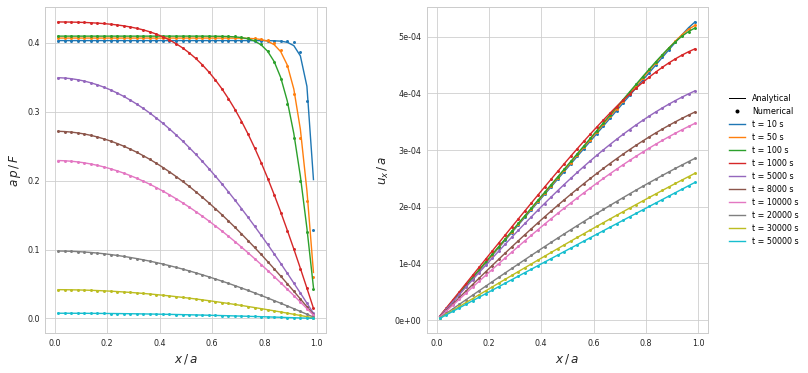

In [21]:
# Retrieving some necessary data
plot_levels = [1, 5, 10, 100, 500, 800, 1000, 2000, 3000, 5000]
F_load = data[pp.PARAMETERS][kw_m]["applied_load"]
[Nx, Ny] = g.cart_dims
a = g.bounding_box()[1][0]
xc = g.cell_centers[0]

# Setting style
sns.set_context("paper")      # set's the scale and size of figures
sns.set_palette("tab10", 10)  # color palette (up to 10 colors)
itertools.cycle(sns.color_palette())  # iterate if > 10 colors are needed

# Creating subplots windows
fig1 = plt.figure(constrained_layout=False, figsize=(10,6))
gs1 = fig1.add_gridspec(nrows=1, ncols=1, left=0.01, right=0.40)
gs2 = fig1.add_gridspec(nrows=1, ncols=1, left=0.54, right=0.93)
gs3 = fig1.add_gridspec(nrows=1, ncols=1, left=0.95, right=0.99)

# Assingning one frame to each plot
with sns.axes_style("whitegrid"):  # assign the style
    ax1 = fig1.add_subplot(gs1[0, 0])
    ax2 = fig1.add_subplot(gs2[0, 0])
ax3 = fig1.add_subplot(gs3[0, 0])

# Legend Plot (Analytical and numerical)
ax3.plot([], [], "-k", linewidth=1, label="Analytical")
ax3.plot([], [], "ok", label="Numerical", markersize=4)

# Pressure, displacement and legends
for i, level in enumerate(plot_levels):

    color = next(ax1._get_lines.prop_cycler)['color']

    # Pressure
    ax1.plot(xc[:Nx]/a, sol["pressure"][level][:Nx]*a/F_load, color=color)
    ax1.plot(xc[:Nx]/a, mandel_dict["pressure"][level][:Nx]*a/F_load, "o", markersize=3, color=color)

    # Displacement
    ax2.plot(xc[:Nx]/a, sol["displacement"][level][::2][:Nx]/a, color=color)
    ax2.plot(xc[:Nx]/a, mandel_dict["displacement"][level][::2][:Nx]/a, "o", color=color, markersize=3)

    # Legends
    ax3.plot([], [], color=color, label='t = {} s'.format(time_values[level]))

# Labels and formatting
ax1.tick_params(axis="both", which="major")
ax1.set_xlabel(r"$x\,/\,a$", fontsize=12)
ax1.set_ylabel(r"$a\,p\,/\,F$", fontsize=12)

ax2.yaxis.set_major_formatter(FormatStrFormatter("%.e"))
ax2.tick_params(axis='both', which='major')
ax2.set_xlabel(r'$x\,/\,a$', fontsize=12)
ax2.set_ylabel(r'$u_x\,/\,a$', fontsize=12)

ax3.legend(loc="center left", frameon=False)
ax3.axis("off")

plt.show()

## References
<a id='ref'></a>

[1]: *Mandel, J. (1953). Consolidation des sols (étude mathématique). Geotechnique, 3(7), 287-299.*

[2]: *Abousleiman, Y., Cheng, A. D., Cui, L., Detournay, E., & Roegiers, J. C. (1996). Mandel's problem revisited. Geotechnique, 46(2), 187-195.*

[3]: *Phillips, P. J., & Wheeler, M. F. (2007). A coupling of mixed and continuous Galerkin finite element methods for poroelasticity I: the continuous in time case. Computational Geosciences, 11(2), 131.*

[4]: *Borregales, M., Kumar, K., Radu, F. A., Rodrigo, C., & Gaspar, F. J. (2018). A parallel-in-time fixed-stress splitting method for Biot's consolidation model. arXiv preprint arXiv:1802.00949.*